In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import cnvutils

In [2]:
CHROMOSOME = '8'
ARM = 'p'
TRANS_OR_CIS = 'cis'

In [3]:
ttest_results_file = f"{CHROMOSOME}{ARM}_{TRANS_OR_CIS}effects_ttest.tsv"

ttest_results = pd.\
read_csv(ttest_results_file, sep="\t").\
rename(columns={"Name": "protein"}).\
set_index("protein")
id_cols = [col for col in ttest_results.columns if not 'Database_ID' in col]
ttest_results = ttest_results[id_cols]
pvalue_cols = [col for col in ttest_results.columns if 'pvalue' in col]
ttest_results = ttest_results[pvalue_cols]

In [4]:
ttest_results

,brca_pvalue,colon_pvalue,hnscc_pvalue,lscc_pvalue,luad_pvalue,ovarian_pvalue
protein,,,,,,
ADAMDEC1,8.742524e-01,5.845904e-01,0.755645,0.853198,1.421191e-01,0.369805
AGPAT5,1.388856e-03,1.167418e-03,0.001309,0.095018,1.900678e-04,0.008375
ANGPT2,5.362941e-01,NaN,0.915747,0.708190,5.195903e-01,0.369805
ARHGEF10,1.357847e-03,5.845904e-01,0.046865,0.368997,2.020514e-03,0.106523
ASAH1,5.790637e-02,1.616228e-02,0.042557,0.863183,1.067770e-01,0.054226
...,...,...,...,...,...,...
STMN4,3.672521e-01,NaN,NaN,NaN,NaN,NaN
TDRP,4.123234e-01,NaN,0.018641,0.176642,1.461906e-01,0.160730
TNKS,1.664952e-02,NaN,0.267128,0.862369,2.553900e-01,0.628983


In [5]:
summary_file = f"pancancer_summary_{CHROMOSOME}{ARM}_{TRANS_OR_CIS}.tsv"
summary = pd.read_csv(summary_file, sep="\t", index_col=0)

In [6]:
def get_cancer(val):
    val_list = val.split('_')
    return val_list[0].upper()

In [7]:
ttest_results_long = ttest_results.reset_index().melt(id_vars='protein', var_name='cancer').sort_values('protein')
ttest_results_long['cancer'] = ttest_results_long.cancer.apply(get_cancer)
ttest_results_long

,protein,cancer,value
0,ADAMDEC1,BRCA,8.742524e-01
198,ADAMDEC1,HNSCC,7.556452e-01
495,ADAMDEC1,OVARIAN,3.698054e-01
396,ADAMDEC1,LUAD,1.421191e-01
99,ADAMDEC1,COLON,5.845904e-01
...,...,...,...
395,XPO7,LSCC,5.858279e-04
197,XPO7,COLON,1.746839e-09
98,XPO7,BRCA,1.317128e-08
494,XPO7,LUAD,9.252022e-09


In [8]:
results = ttest_results_long.set_index('protein').join(summary, how='left')
results = results.reset_index()
results['num_cancers'] = results.num_cancers.fillna(0)

In [9]:
locations = cnvutils.get_gene_locations()
# locations.index
locations = locations.droplevel(1)

In [10]:
def make_pvalue_plot(df, label_column, value_column, group_column=None, sort_column=None, sort_ascending=True, sig=0.5, show_sig=True):
    """
    @param df:
        The dataframe with pvalue information
    @param label_column:
        The name of the column that contains the labels for the x-axis of the figure
    @param value_column: 
        The name of the column that contains the pvalues to be plotted
    @param group_column (optional):
        The name of the column that contains a grouping category. If provided, the groups will be indicated by color and
        a legend will be added to the figure
    @param sort_column (optional):
        The name of the column to sort the values on before plotting.
    @param sort_ascending
        Sort ascending vs. descending. This variable will only be used if sort_column is not None. Otherwise values will be
        plotted by position in the dataframe provided.
    @param sig:
        The significance value (before log transformation) to be plotted for comparison. The line can be turned off using the
        show_sig parameter.
    @param show_sig:
        Determines whether the significance line is shown in the plot.
    """
    
    df_copy = df.copy()
    df_copy['log_val'] = results[value_column].apply(lambda x: -np.log10(x))
    if sort_column:
        df_copy.sort_values(sort_column, ascending=sort_ascending)
    def chunks(lst, n):
        """Yield successive n-sized chunks from lst."""
        x = list()
        for i in range(0, len(lst), n):
            x.append(lst[i:i + n])
        return x
    split_results = chunks(results[label_column].unique(), 30)
    def set_group(row):
        for i in range(len(split_results)):
            if row.protein in split_results[i]:
                return i
    df_copy['group_num'] = df_copy.apply(set_group, axis=1)
    if group_column:
        df_copy = df_copy.drop_duplicates(subset=[label_column, value_column, group_column])
    else:
        df_copy = df_copy.drop_duplicates(subset=[label_column, value_column])
    g = sns.FacetGrid(df_copy, row="group_num", aspect=4, sharex=False, sharey=False, legend_out=True)
    if group_column:
        g.map_dataframe(sns.swarmplot, x=label_column, y="log_val", hue=group_column, palette='muted')
        g.add_legend()
    else:
        g.map_dataframe(sns.swarmplot, x=label_column, y="log_val", palette="muted")
    for ax in g.axes.ravel():
        ax.hlines(-np.log10(sig),*ax.get_xlim())
        ax.set_title("")
        plt.setp(ax.xaxis.get_majorticklabels(), rotation=90)


In [11]:
def log_transform(val):
    return -np.log10(val)

In [12]:
results['log_val'] = results.value.apply(log_transform)

In [13]:
results_1 = results.set_index('protein')
results = results_1.join(locations)
results.index.rename('protein', inplace=True)
results = results.reset_index()

In [14]:
results = results.sort_values('start_bp')

In [15]:
results = results.reset_index()
results = results.reset_index()

In [16]:
len(results.protein.unique())

79

In [17]:
def chunks(lst, n):
    """Yield successive n-sized chunks from lst."""
    x = list()
    for i in range(0, len(lst), n):
        x.append(lst[i:i + n])
    return x

In [18]:
split_results = chunks(results.protein.unique(), 30)

In [19]:
def set_group(row):
    for i in range(len(split_results)):
        if row.protein in split_results[i]:
            return i

In [20]:
results['group'] = results.apply(set_group, axis=1)

In [21]:
results[(results.protein == 'CCDC25') & (results.cancer=='LUAD')]

,level_0,index,protein,cancer,value,cancers,mean_simp_change,num_cancers,log_val,chromosome,start_bp,end_bp,arm,group
1518,1518,234,CCDC25,LUAD,5.489574e-02,luad,-1.0,1.0,1.260461,8,27733316.0,27772653.0,p,2
1519,1519,235,CCDC25,LUAD,5.489574e-02,luad,-1.0,1.0,1.260461,8,27733316.0,27772653.0,p,2
1520,1520,236,CCDC25,LUAD,5.489574e-02,luad,-1.0,1.0,1.260461,8,27733316.0,27772653.0,p,2
1521,1521,237,CCDC25,LUAD,4.239245e-09,luad,-1.0,1.0,8.372711,8,27733316.0,27772653.0,p,2
1522,1522,238,CCDC25,LUAD,4.239245e-09,luad,-1.0,1.0,8.372711,8,27733316.0,27772653.0,p,2
1523,1523,239,CCDC25,LUAD,4.239245e-09,luad,-1.0,1.0,8.372711,8,27733316.0,27772653.0,p,2


In [22]:
all_cancer_types = ['BRCA', 'COLON', 'CCRCC', 'ENDO', 'GBM', 'HNSCC', 'LUAD', 'LSCC', 'OVARIAN']
colors = sns.color_palette('tab10', n_colors=9)
color_dict = dict()
for i in range(9):
    color_dict[all_cancer_types[i]] = colors[i]
    
print(color_dict)

{'BRCA': (0.12156862745098039, 0.4666666666666667, 0.7058823529411765), 'COLON': (1.0, 0.4980392156862745, 0.054901960784313725), 'CCRCC': (0.17254901960784313, 0.6274509803921569, 0.17254901960784313), 'ENDO': (0.8392156862745098, 0.15294117647058825, 0.1568627450980392), 'GBM': (0.5803921568627451, 0.403921568627451, 0.7411764705882353), 'HNSCC': (0.5490196078431373, 0.33725490196078434, 0.29411764705882354), 'LUAD': (0.8901960784313725, 0.4666666666666667, 0.7607843137254902), 'LSCC': (0.4980392156862745, 0.4980392156862745, 0.4980392156862745), 'OVARIAN': (0.7372549019607844, 0.7411764705882353, 0.13333333333333333)}


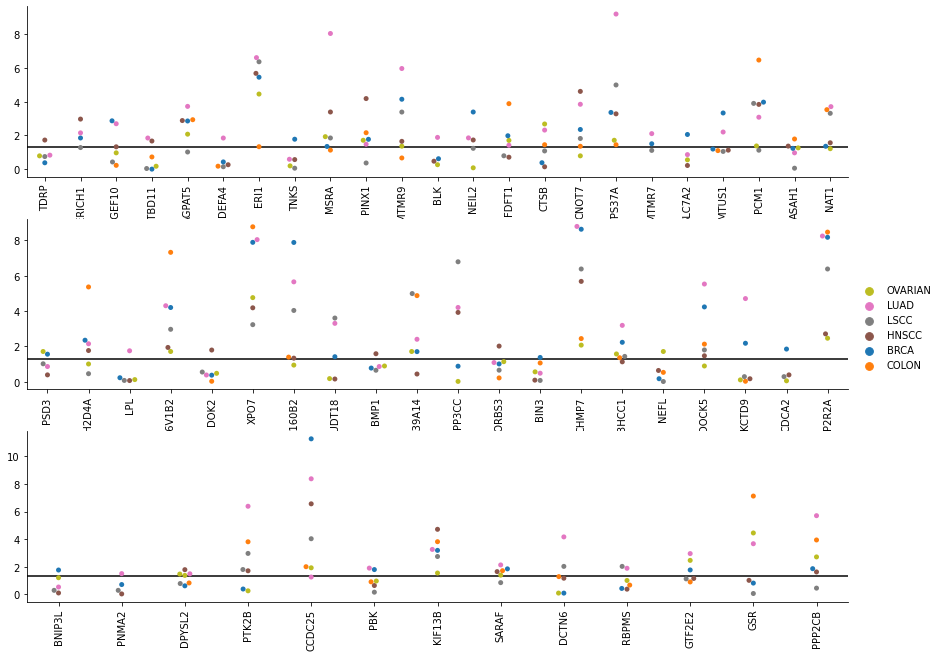

In [23]:
results = results.drop_duplicates(subset=['protein', 'cancer', 'log_val'])
# results['color'] = results.cancer.apply(lambda x: color_dict[x])
# print(results)
# palette = [color_dict[x] for x in results.cancer.unique()]

# print(results.cancer.unique())
g = sns.FacetGrid(results, row="group", aspect=4, sharex=False, sharey=False, legend_out=True)
g.map_dataframe(sns.swarmplot, x="protein", y="log_val", hue='cancer', palette=color_dict)
leg = g.add_legend()
# leg = g._legend
# hl_dict = {handle.get_label(): handle for handle in leg.legendHandles}
# hl_dict['']
# print(hl_dict)
# for label in hl_dict.keys():
#     hl_dict[label].set_color(color_dict[label])
# print(leg.legendHandles)
# print(g._legend.get_legend_handler_map())
for ax in g.axes.ravel():
    ax.hlines(-np.log10(0.05),*ax.get_xlim())
    ax.set_title("")
#     print(ax.get_legend_handler_map())
#     print(ax.get_legend_handles_labels()[1])
#     leg = ax.get_legend()
#     print(leg.legendHandles)
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=90)
# ax = plt.gca()

# print(hl_dict)
# g.set_axis_labels("Total bill", "Tip")
# g.set_titles(col_template="{col_name} patrons", row_template="{row_name}")
# g.set(xlim=(0, 60), ylim=(0, 12), xticks=[10, 30, 50], yticks=[2, 6, 10])
# g.tight_layout()

In [24]:
print(results.cancer.unique())

['OVARIAN' 'LUAD' 'LSCC' 'HNSCC' 'COLON' 'BRCA']
